# IMA201 Project : Increasing Depth of Field by Image Fusion

*Elaborated by:*

- **Lina BELLAHMIDI**
- **Atef BOUZID**

*Supervised by:* 

- **Mr. Saïd LADJAL**

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.io import imread,imsave
from scipy.signal import convolve, convolve2d
import cv2
from tqdm import tqdm

import mrlab as mr

import warnings

In [2]:
def to_32F(image):
    """
    Convert an image to 32-bit float in [0, 1] range.
    Ensures that all values are strictly within the [0, 1] interval by clipping after conversion.

    Args:
        image (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: 32-bit float image, strictly within the [0, 1] range.
    """
    # Normalize only if the maximum value is greater than 1 to handle already normalized images
    if image.max() > 1.0:
        image = image.astype(np.float32) / 255.0
    else:
        image = image.astype(np.float32)
    
    # Clip to remove negative values due to floating point arithmetic issues
    return np.clip(image, 0.0, 1.0)

# Using predifined Guided filter by Opencv

In [3]:
# !pip install opencv-contrib-python
from cv2.ximgproc import guidedFilter

In [4]:
help(guidedFilter)

Help on built-in function guidedFilter:

guidedFilter(...)
    guidedFilter(guide, src, radius, eps[, dst[, dDepth[, scale]]]) -> dst
    .   @brief Simple one-line (Fast) Guided Filter call.
    .
    .   If you have multiple images to filter with the same guided image then use GuidedFilter interface to
    .   avoid extra computations on initialization stage.
    .
    .   @param guide guided image (or array of images) with up to 3 channels, if it have more then 3
    .   channels then only first 3 channels will be used.
    .
    .   @param src filtering image with any numbers of channels.
    .
    .   @param dst output image.
    .
    .   @param radius radius of Guided Filter.
    .
    .   @param eps regularization term of Guided Filter. \f${eps}^2\f$ is similar to the sigma in the color
    .   space into bilateralFilter.
    .
    .   @param dDepth optional depth of the output image.
    .
    .   @param scale subsample factor of Fast Guided Filter, use a scale less than 1 to 

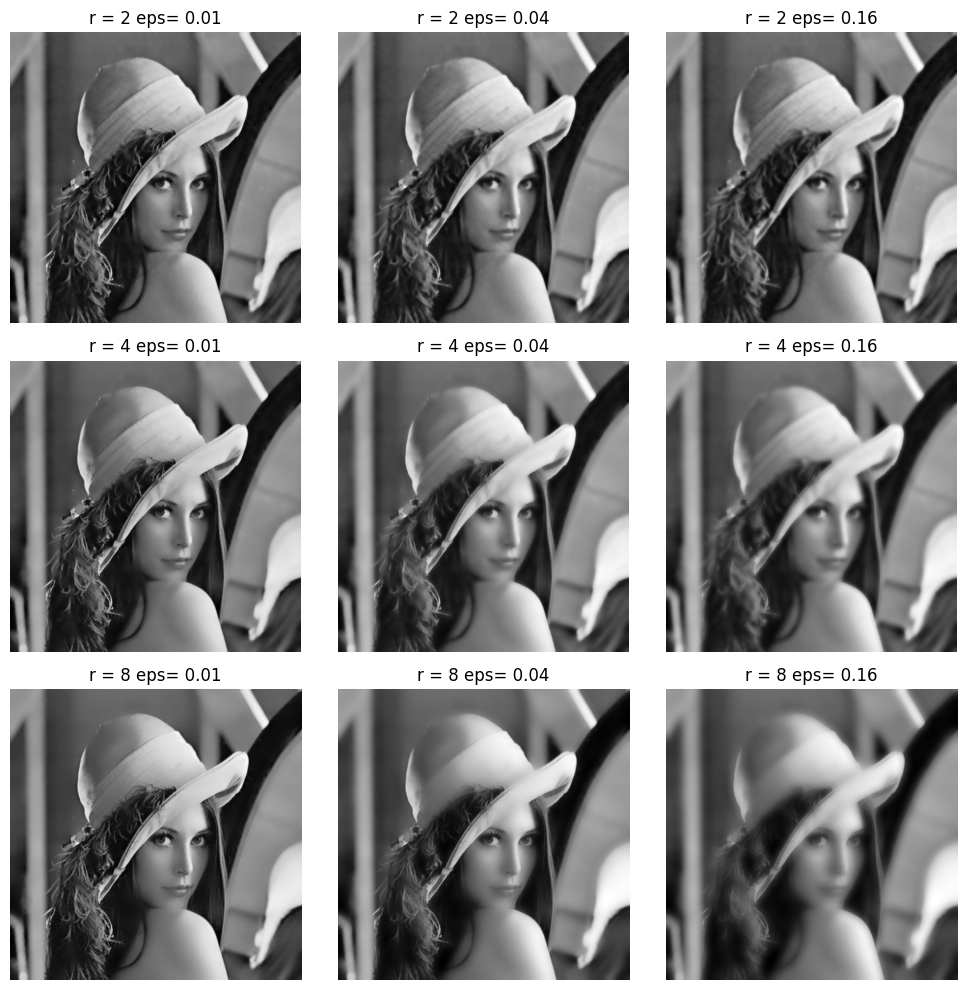

In [5]:
image=io.imread("dataset/lena.tif")
image = to_32F(image)
titles =[(2,0.01),(2,0.04),(2,0.16),(4,0.01),(4,0.04),(4,0.16),(8,0.01),(8,0.04),(8,0.16)]

images = []

images.append(guidedFilter(image,image,2, 0.01))
images.append(guidedFilter(image,image,2, 0.2**2))
images.append(guidedFilter(image,image,2, 0.4**2))

images.append(guidedFilter(image,image,4, 0.01))
images.append(guidedFilter(image,image,4, 0.2**2))
images.append(guidedFilter(image,image,4, 0.4**2))

images.append(guidedFilter(image,image,8, 0.01))
images.append(guidedFilter(image,image,8, 0.2**2))
images.append(guidedFilter(image,image,8, 0.4**2))



fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i * 3 + j < len(images):
            ax.imshow(images[i * 3 + j],cmap='gray')
            #ax.set_title(f'Image {i * 3 + j + 1}')
            ax.set_title(f'r = {titles[i * 3 + j ][0]} eps= {titles[i * 3 + j ][1]}')
            ax.axis('off')
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.049911316..1.0494776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0023589376..1.0184869].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0390226..1.0563692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0019316329..1.0373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05214235..1.0694749].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006555019..1.087283].


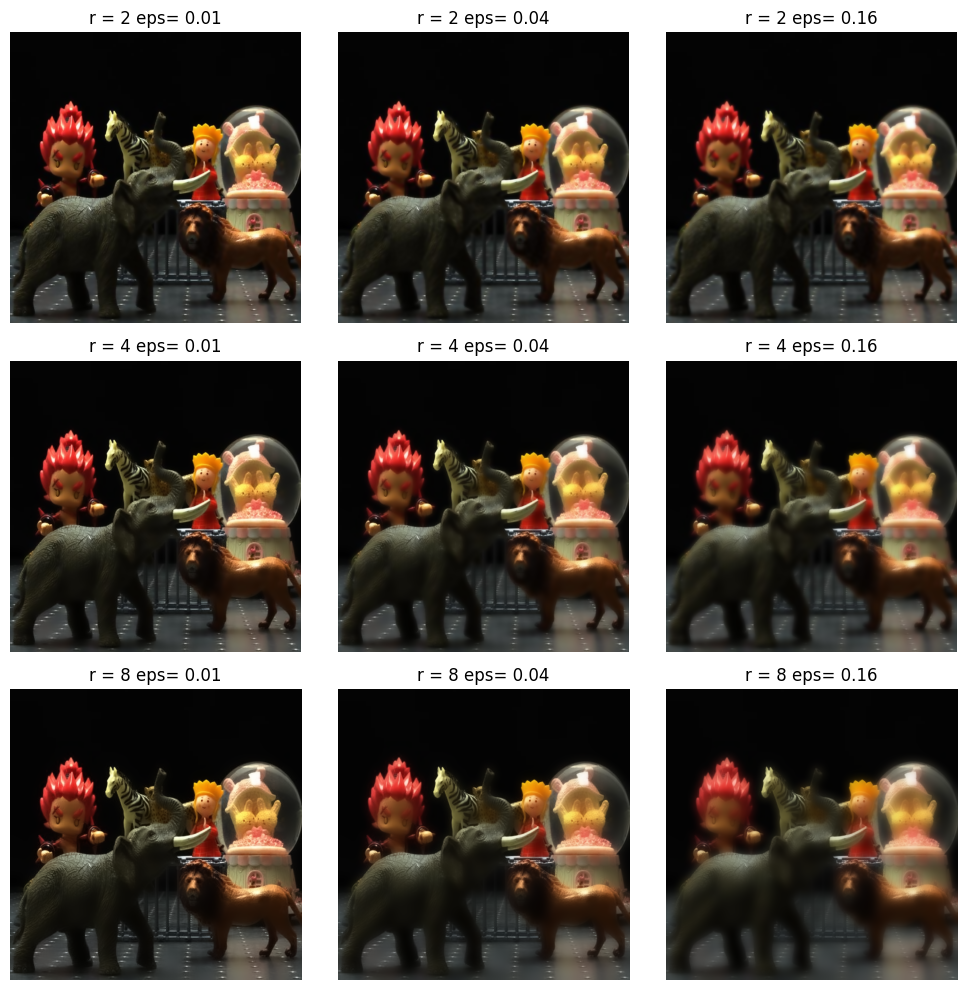

In [6]:
image=io.imread("dataset/Ground_truth/986/986.png")
image = to_32F(image)

titles =[(2,0.01),(2,0.04),(2,0.16),(4,0.01),(4,0.04),(4,0.16),(8,0.01),(8,0.04),(8,0.16)]

images = []

images.append(guidedFilter(image,image,2, 0.01))
images.append(guidedFilter(image,image,2, 0.2**2))
images.append(guidedFilter(image,image,2, 0.4**2))

images.append(guidedFilter(image,image,4, 0.01))
images.append(guidedFilter(image,image,4, 0.2**2))
images.append(guidedFilter(image,image,4, 0.4**2))

images.append(guidedFilter(image,image,8, 0.01))
images.append(guidedFilter(image,image,8, 0.2**2))
images.append(guidedFilter(image,image,8, 0.4**2))



fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i * 3 + j < len(images):            
            ax.imshow(images[i * 3 + j])
            #ax.set_title(f'Image {i * 3 + j + 1}')
            ax.set_title(f'r = {titles[i * 3 + j ][0]} eps= {titles[i * 3 + j ][1]}')
            ax.axis('off')
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

# Implementation of Guided Filtering Technique

## Utility functions

In [7]:
def filtre_lineaire(im,mask):
    """ 
    renvoie la convolution de l'image avec le mask. Le calcul se fait en 
    utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
    les images en niveau de gris.
    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def compute_mean_window(im, r=2):
    """
    Compute the local mean of an image using a square window of side length (2*r + 1).
    Args:
        im (numpy.ndarray): Input image (grayscale).
        r (int): Radius of the window, where the window side length is (2*r + 1).
    Returns:
        numpy.ndarray: The image where each pixel contains the mean of its local neighborhood.
    """
    mask = np.ones((2*r+1, 2*r+1))  # Creates a square mask
    mask = mask / mask.sum()        
    return filtre_lineaire(im, mask)

def compute_variance_window(im1, im2, r=2):
    """
    Compute the covariance between two images, or variance of one image if the same image is passed as both inputs.
    Args:
        im1 (numpy.ndarray): First input image (grayscale).
        im2 (numpy.ndarray): Second input image (grayscale); pass the same as im1 for variance.
        r (int): Radius of the window used to calculate the means.
    Returns:
        numpy.ndarray: Variance or covariance of the images within each local window.
    """
    cov_im1_im2 = compute_mean_window(im1 * im2, r) - compute_mean_window(im1, r) * compute_mean_window(im2, r)
    return cov_im1_im2

def guided_filter_gray_images(I, P, r=2, eps=1e-8):
    """
    Apply a guided filter to a grayscale image for edge-preserving smoothing.
    Args:
        I (numpy.ndarray): The input image (grayscale) to be filtered.
        P (numpy.ndarray): The guidance image (grayscale).
        r (int): Radius of the window used in mean and variance calculations.
        eps (float): Regularization parameter to avoid division by zero.
    Returns:
        numpy.ndarray: The output filtered image.
    """
    assert (len(I.shape) == 2) and (len(P.shape) == 2), 'Please give a gray image!'  # Validation for grayscale images

    u_k = compute_mean_window(P, r)
    delta_k = compute_variance_window(P, P, r)
    I_mean = compute_mean_window(I, r)

    # Linear regression
    a_k = (compute_mean_window(I*P , r) - u_k * I_mean) / (delta_k + eps)
    b_k = I_mean - a_k * u_k

    # Mean values 
    a_mean = compute_mean_window(a_k, r)
    b_mean = compute_mean_window(b_k, r)

    # Output 
    O = a_mean * I + b_mean
    return O

def guided_filter_color_images(P, I, r=2, eps=1e-8):
    """
    Apply a guided filter to each channel of a color image using corresponding channels 
    of a color guidance image for edge-preserving smoothing. This function assumes that 
    the guidance image P has the same spatial dimensions as I and is also a color image.

    Args:
        I (numpy.ndarray): The input image (color) to be filtered.
        P (numpy.ndarray): The guidance image (color).
        r (int): Radius of the window used in mean and variance calculations.
        eps (float): Regularization parameter to avoid division by zero.

    Returns:
        numpy.ndarray: The output filtered image where each color channel has been 
        independently guided by the corresponding channel of P.
    """
    assert I.shape[2] == 3 and len(I.shape) == 3, 'Please provide color images with three channels!'
    O = np.zeros_like(I)

    if len(P.shape)==3:
        assert P.shape[2] == 3, 'the guidance image (in case it is a color image), it should have 3 channels'
        for i in range(3): # 3 channels (RGB)
            O[..., i] = guided_filter_gray_images(I[..., i], P[..., i], r, eps)
    else:
        assert len(P.shape) == 2, 'the guidance image should be a gray image or with 3 channels (RGB)'

        # we should ask mr said about it 
    
    return O

def guided_filter(I, P, r=2, eps=1e-8):
    P = to_32F(P)
    I = to_32F(I)

    if (len(I.shape) == 2) and (len(P.shape) == 2):
        result = guided_filter_gray_images(I, P, r, eps)
    elif (len(I.shape) == 3) and (len(P.shape) == 3):
        result = guided_filter_color_images(I, P, r, eps)
    else:
        raise ValueError('You should use the same shape for the Image and the guidance for now')
    
    # Ensure that the output is strictly within [0, 1]
    result = np.clip(result, 0.0, 1.0)
    return result

## Test 

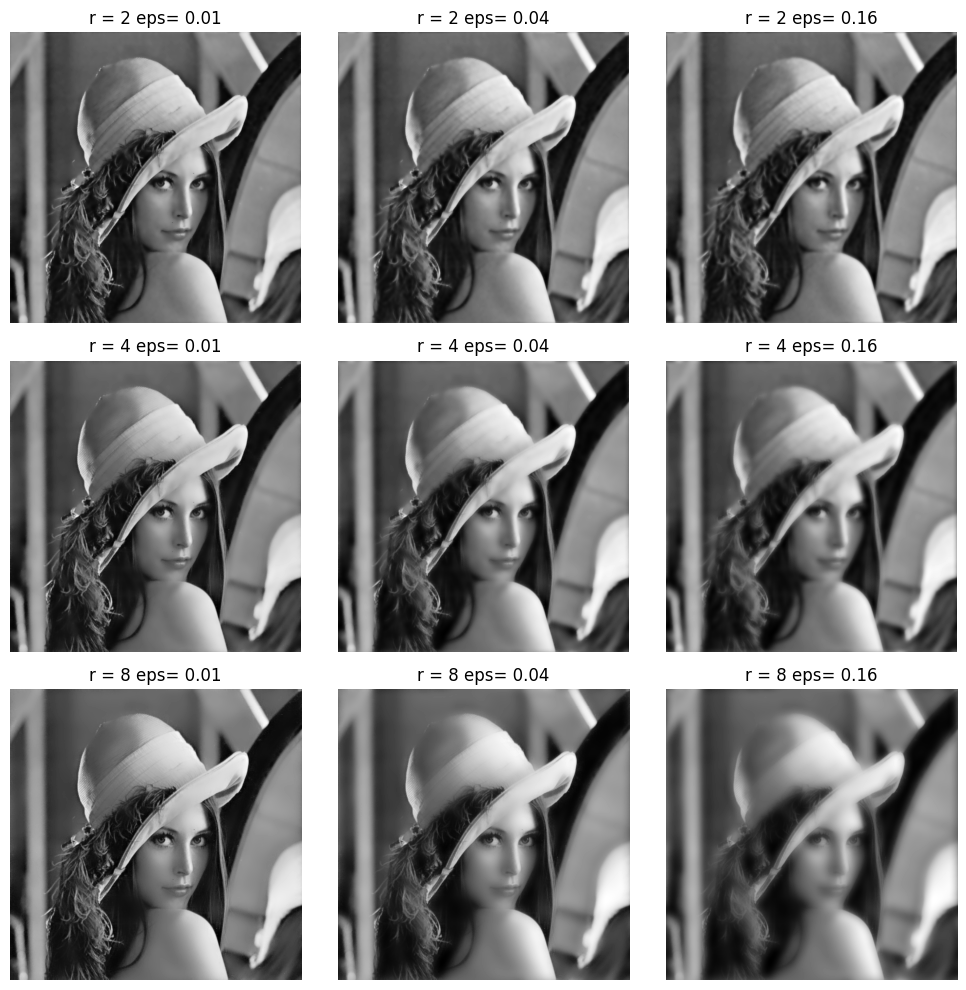

In [8]:
image=io.imread("dataset/lena.tif")
titles =[(2,0.01),(2,0.04),(2,0.16),(4,0.01),(4,0.04),(4,0.16),(8,0.01),(8,0.04),(8,0.16)]

images = []

images.append(guided_filter(image,image,2, 0.01))
images.append(guided_filter(image,image,2, 0.2**2))
images.append(guided_filter(image,image,2, 0.4**2))

images.append(guided_filter(image,image,4, 0.01))
images.append(guided_filter(image,image,4, 0.2**2))
images.append(guided_filter(image,image,4, 0.4**2))

images.append(guided_filter(image,image,8, 0.01))
images.append(guided_filter(image,image,8, 0.2**2))
images.append(guided_filter(image,image,8, 0.4**2))



fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i * 3 + j < len(images):
            ax.imshow(images[i * 3 + j],cmap='gray')
            #ax.set_title(f'Image {i * 3 + j + 1}')
            ax.set_title(f'r = {titles[i * 3 + j ][0]} eps= {titles[i * 3 + j ][1]}')
            ax.axis('off')
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

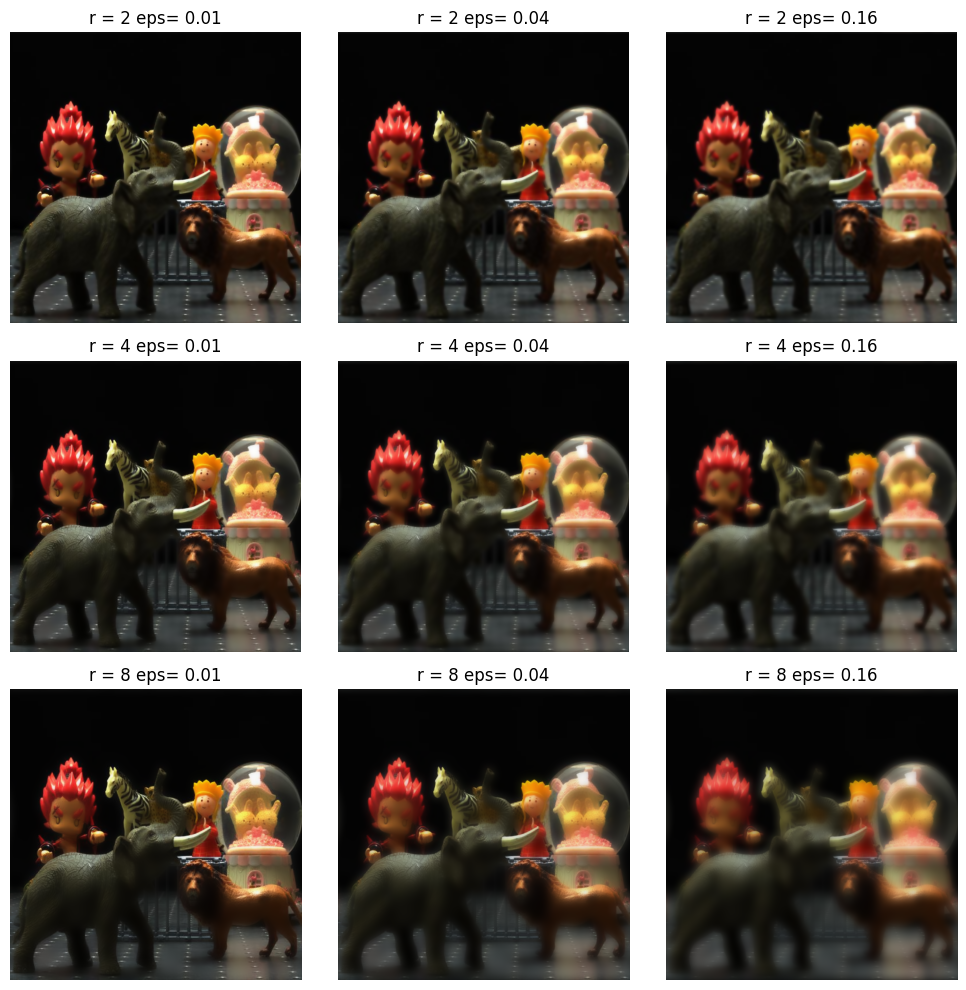

In [9]:
image=io.imread("dataset/Ground_truth/986/986.png")
GF1 = guided_filter(image,image,7, 0.3)
titles =[(2,0.01),(2,0.04),(2,0.16),(4,0.01),(4,0.04),(4,0.16),(8,0.01),(8,0.04),(8,0.16)]

images = []

images.append(guided_filter(image,image,2, 0.01))
images.append(guided_filter(image,image,2, 0.2**2))
images.append(guided_filter(image,image,2, 0.4**2))

images.append(guided_filter(image,image,4, 0.01))
images.append(guided_filter(image,image,4, 0.2**2))
images.append(guided_filter(image,image,4, 0.4**2))

images.append(guided_filter(image,image,8, 0.01))
images.append(guided_filter(image,image,8, 0.2**2))
images.append(guided_filter(image,image,8, 0.4**2))



fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i * 3 + j < len(images):
            ax.imshow(images[i * 3 + j],cmap='gray')
            #ax.set_title(f'Image {i * 3 + j + 1}')
            ax.set_title(f'r = {titles[i * 3 + j ][0]} eps= {titles[i * 3 + j ][1]}')
            ax.axis('off')
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

## IMAGE FUSION WITH GUIDED FILTERING

### A. Two-Scale Image Decomposition

In [10]:
def get_cst_ker(t):
    return np.ones((t,t))/t**2

def base_layer(im,n_mask = 3):
    """ Calcul du base layer en appliquant un filre moyenneur qui calcule la
    moyenne avec les 8 voisins du pixel """
    return filtre_lineaire(im, get_cst_ker(n_mask))

def details_layer(im,base_im):
    """ Le details layer est calculé en faisant la différence entre l'image 
    originale et son base layer"""
    return np.float32(im)-np.float32(base_im)

### Test on gray image

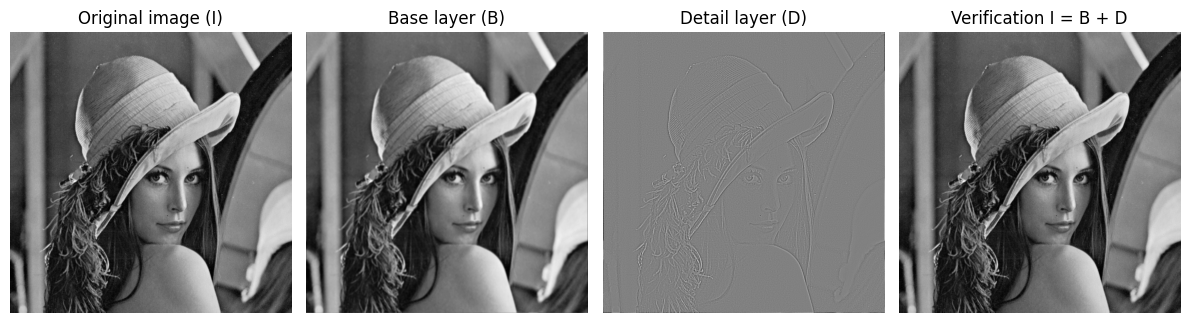

In [11]:
im = io.imread('dataset/lena.tif')
B = base_layer(im)
D = details_layer(im,B)

plt.figure(figsize=(12,5))

plt.subplot(141)
plt.title('Original image (I)')
plt.imshow(im,cmap='gray')
plt.axis('off')

plt.subplot(142)
plt.title('Base layer (B)')
plt.imshow(B,cmap='gray')
plt.axis('off')

plt.subplot(143)
plt.title('Detail layer (D)')
plt.imshow(D,cmap='gray')
plt.axis('off')

plt.subplot(144)
plt.title('Verification I = B + D')
plt.imshow(B+D,cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### B. Weight Map Construction With Guided Filtering

In [12]:
def get_gau_ker(r,s):
    ss=int(2*r+1)
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out


def filtre_laplacien1(im):
    """Convolution non linéaire entre le noyau laplacien de taille 3 et de l'image source"""
    L = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]]) #noyau de taille 3 typiquemnent utilisé pour le filtre la placien
    # Covolution entre l'image source et le noyau laplacien
    H_im = signal.convolve2d(im,L,mode='same',boundary='fill')
    return H_im

def filtre_laplacien2(ima):
    """Calcul du laplacien comme dans le TP (donne de meilleurs résultats à mon avis) """
    alpha=0.5

    gradx=mr.dericheGradX(mr.dericheSmoothY(ima,alpha),alpha)
    grady=mr.dericheGradY(mr.dericheSmoothX(ima,alpha),alpha)  

    gradx2=mr.dericheGradX(mr.dericheSmoothY(gradx,alpha),alpha)
    grady2=mr.dericheGradY(mr.dericheSmoothX(grady,alpha),alpha)

    return gradx2+grady2


def saliency_map(ima):
    """ Calcul le laplacien de l'image ensuite applique à sa valeur absolue
     un filtre passe bas gaussien 
    d'écart type = 5 et de taille 11x11"""

    H_im = filtre_laplacien2(ima)
    S = filtre_lineaire(abs(H_im),get_gau_ker(5,5))
    return S

def weight_map(S1,S2):
    mask = np.uint8(np.argmax([S1, S2], axis=0))
    P = np.zeros_like(S1)
    P[mask==0] = 1
    return P

### Test on gray images

In [13]:
%%time 

# Load the images
im1 = cv2.cvtColor(io.imread('dataset/gray/633/633_0.png'), cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(io.imread('dataset/gray/633/633_1.png'), cv2.COLOR_BGR2GRAY)

im1=to_32F(im1)
im2=to_32F(im2)

## Base and detail layer
B1 = base_layer(im1)
B2 = base_layer(im2)
D1 = details_layer(im1,B1)
D2 = details_layer(im2,B2)


## Saliency map 
S1 = saliency_map(im1)
S2 = saliency_map(im2)

## Weight maps
P1 = weight_map(S1,S2)
P2 = weight_map(S2,S1)


# Guided filtering
r_1=45
r_2=7
eps_1=0.3
eps_2=1e-6

W1_B = guided_filter(im1,P1, r_1, eps_1)
W2_B = guided_filter(im2,P2, r_1, eps_1)
W1_D = guided_filter(im1,P1, r_2, eps_2)
W2_D = guided_filter(im2,P2, r_2, eps_2)

# Normalize the Range: we shift the range of values so that the minimum value is now zero.
W1_B=W1_B-W1_B.min()
W2_B=W2_B-W2_B.min()
W1_D=W1_D-W1_D.min()
W2_D=W2_D-W2_D.min()

CPU times: total: 12.5 s
Wall time: 12.5 s


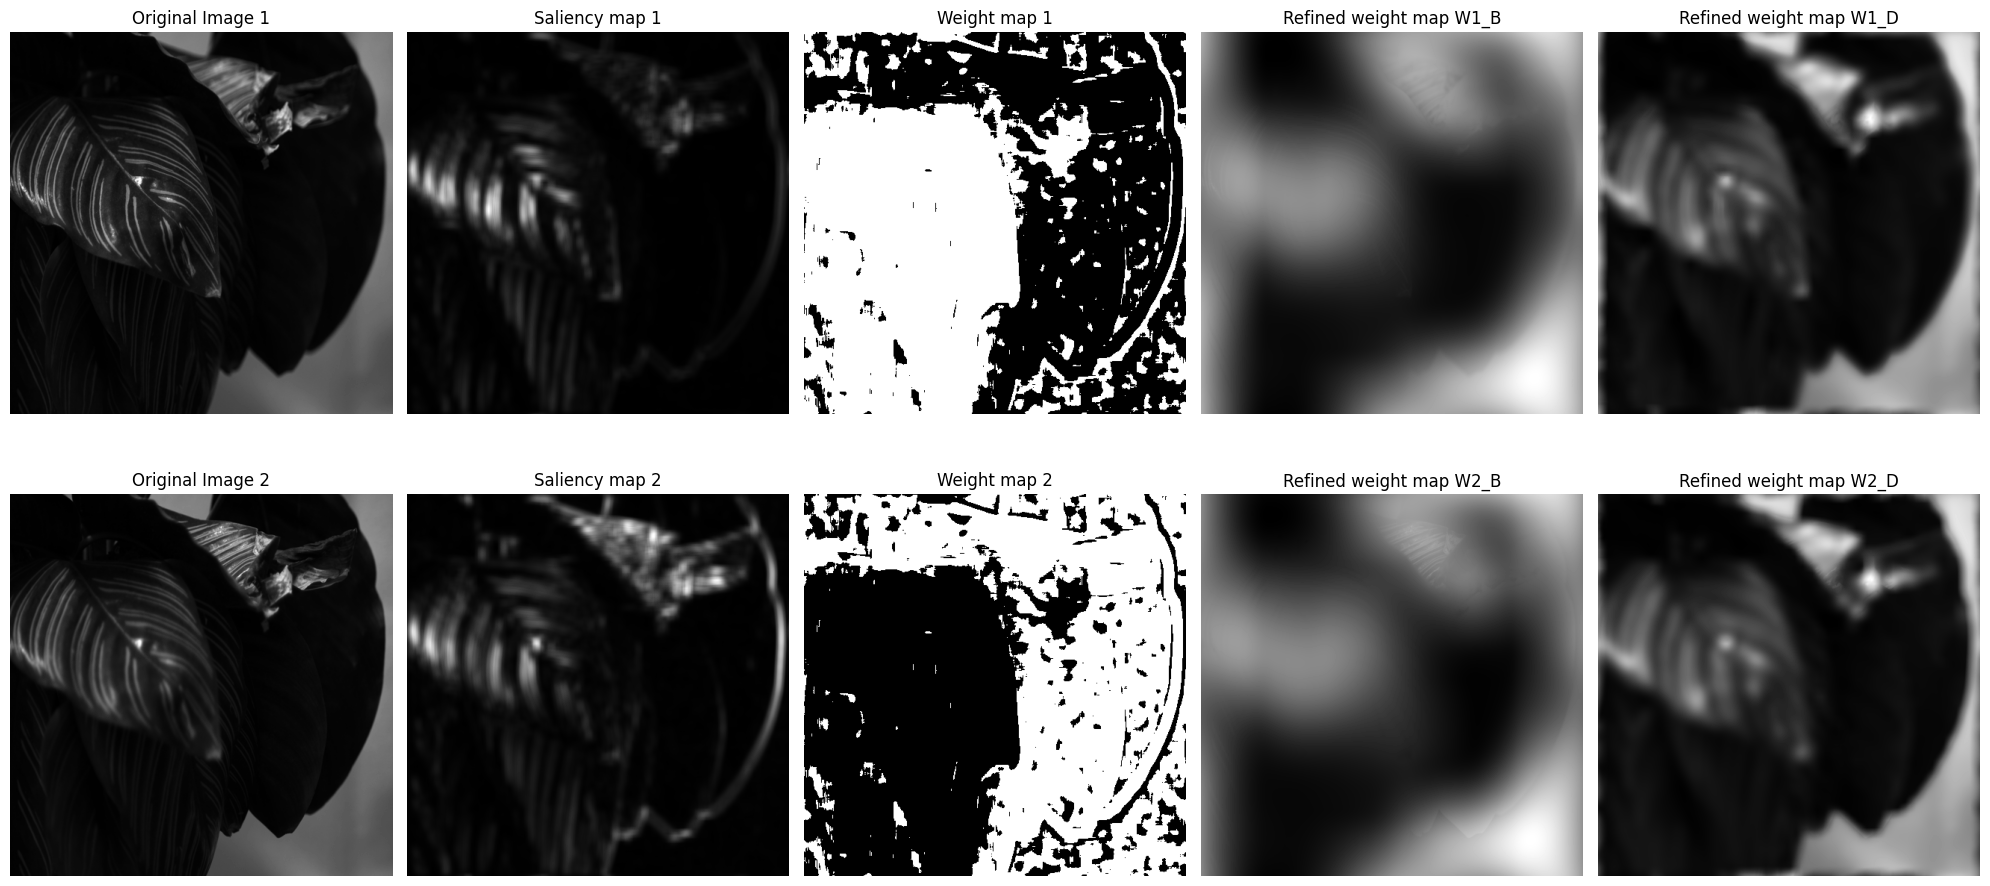

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(251)
plt.title('Original Image 1')
plt.imshow(im1,cmap='gray')
plt.axis('off')

plt.subplot(252)
plt.title('Saliency map 1')
plt.imshow(S1,cmap='gray')
plt.axis('off')

plt.subplot(253)
plt.title('Weight map 1')
plt.imshow(P1,cmap='gray')
plt.axis('off')

plt.subplot(254)
plt.title('Refined weight map W1_B')
plt.imshow(W1_B,cmap='gray')
plt.axis('off')

plt.subplot(255)
plt.title('Refined weight map W1_D')
plt.imshow(W1_D,cmap='gray')
plt.axis('off')

plt.subplot(256)
plt.title('Original Image 2')
plt.imshow(im2,cmap='gray')
plt.axis('off')

plt.subplot(257)
plt.title('Saliency map 2')
plt.imshow(S2,cmap='gray')
plt.axis('off')

plt.subplot(258)
plt.title('Weight map 2')
plt.imshow(P2,cmap='gray')
plt.axis('off')

plt.subplot(259)
plt.title('Refined weight map W2_B')
plt.imshow(W2_B,cmap='gray')
plt.axis('off')

plt.subplot(2,5,10)
plt.title('Refined weight map W2_D')
plt.imshow(W2_D,cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### C. Two-Scale Image Reconstruction

In [15]:
sum_B = W1_B + W2_B
sum_D = W1_D + W2_D

B_hat = W1_B*B1 + W2_B*B2
D_hat = W1_D*D1 + W2_D*D2

F = B_hat + D_hat

# Normalize the fused image 
F = (F - F.min()) / (F.max() - F.min())

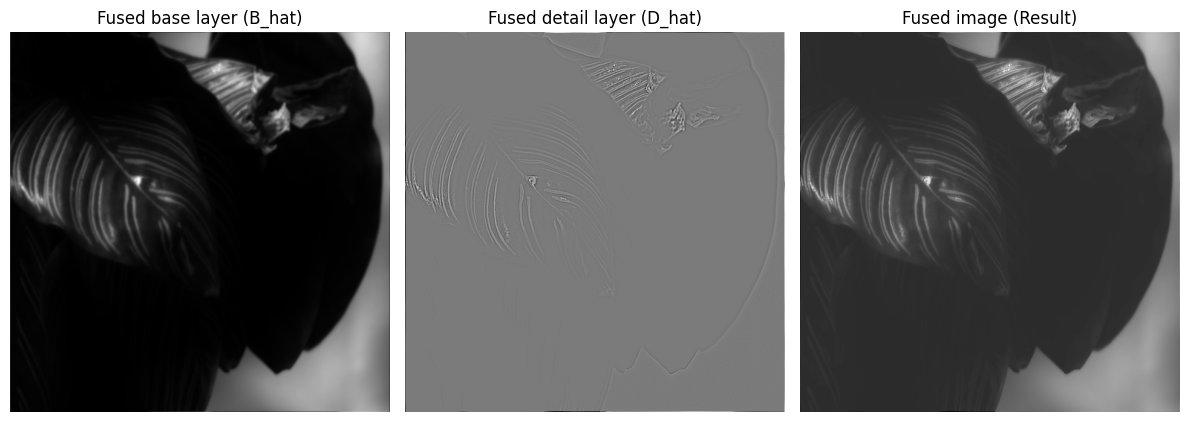

In [16]:
plt.figure(figsize=(12,5))


plt.subplot(131)
plt.title('Fused base layer (B_hat)')
plt.imshow(B_hat,cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Fused detail layer (D_hat)')
plt.imshow(D_hat,cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Fused image (Result)')
plt.imshow(F,cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Guided Filter Fusion - Completed

In [28]:
def guided_filter_fusion(im1, im2, r_1=45, r_2=7, eps_1=0.3, eps_2=1e-6):
    """Fusion of two images using guided filter for depth enhancement."""
    
    # Convert images to 32-bit float
    im1, im2 = to_32F(im1), to_32F(im2)
    
    if im1.ndim == 2:  # Grayscale image
        # Decompose into base and detail layers
        B1, B2 = base_layer(im1), base_layer(im2)
        D1, D2 = details_layer(im1, B1), details_layer(im2, B2)
        
        # Compute saliency maps
        S1, S2 = compute_mean_window(im1, 2), compute_mean_window(im2, 2)
        
        # Construct weight maps
        P1, P2 = weight_map(S1, S2), weight_map(S2, S1)
        
        # Apply guided filtering to refine weight maps
        W1_B = guided_filter(im1, P1, r_1, eps_1)
        W2_B = guided_filter(im2, P2, r_1, eps_1)
        W1_D = guided_filter(im1, P1, r_2, eps_2)
        W2_D = guided_filter(im2, P2, r_2, eps_2)
        
        # Two-scale image reconstruction
        B_hat = W1_B * B1 + W2_B * B2
        D_hat = W1_D * D1 + W2_D * D2
        F = B_hat + D_hat
    
    elif im1.ndim == 3:  # Color image
        F = np.zeros_like(im1)
        for i in range(3):  # Process each channel independently
            # Base and detail layers
            B1, B2 = base_layer(im1[..., i]), base_layer(im2[..., i])
            D1, D2 = details_layer(im1[..., i], B1), details_layer(im2[..., i], B2)
            
            # Saliency maps
            S1, S2 = compute_mean_window(im1[..., i], 2), compute_mean_window(im2[..., i], 2)
            
            # Weight maps
            P1, P2 = weight_map(S1, S2), weight_map(S2, S1)
            
            # Guided filtering to refine weight maps
            W1_B = guided_filter(im1[..., i], P1, r_1, eps_1)
            W2_B = guided_filter(im2[..., i], P2, r_1, eps_1)
            W1_D = guided_filter(im1[..., i], P1, r_2, eps_2)
            W2_D = guided_filter(im2[..., i], P2, r_2, eps_2)
            
            # Two-scale reconstruction for the channel
            B_hat = W1_B * B1 + W2_B * B2
            D_hat = W1_D * D1 + W2_D * D2
            F[..., i] = B_hat + D_hat

    # Normalize fused image
    F = (F - F.min()) / (F.max() - F.min())
    
    return F

### Test

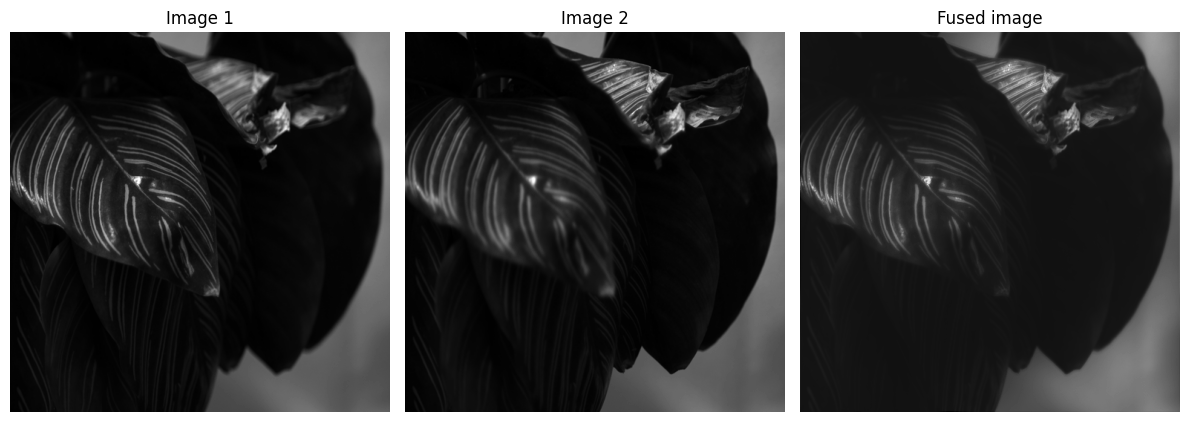

In [29]:
im1 = cv2.cvtColor(io.imread('dataset/gray/633/633_0.png'), cv2.COLOR_RGB2GRAY)
im2 = cv2.cvtColor(io.imread('dataset/gray/633/633_1.png'), cv2.COLOR_RGB2GRAY)

fused_image = guided_filter_fusion(im1, im2)
plt.figure(figsize=(12,5))


plt.subplot(131)
plt.title('Image 1')
plt.imshow(im1,cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Image 2')
plt.imshow(im2,cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Fused image')
plt.imshow(fused_image,cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

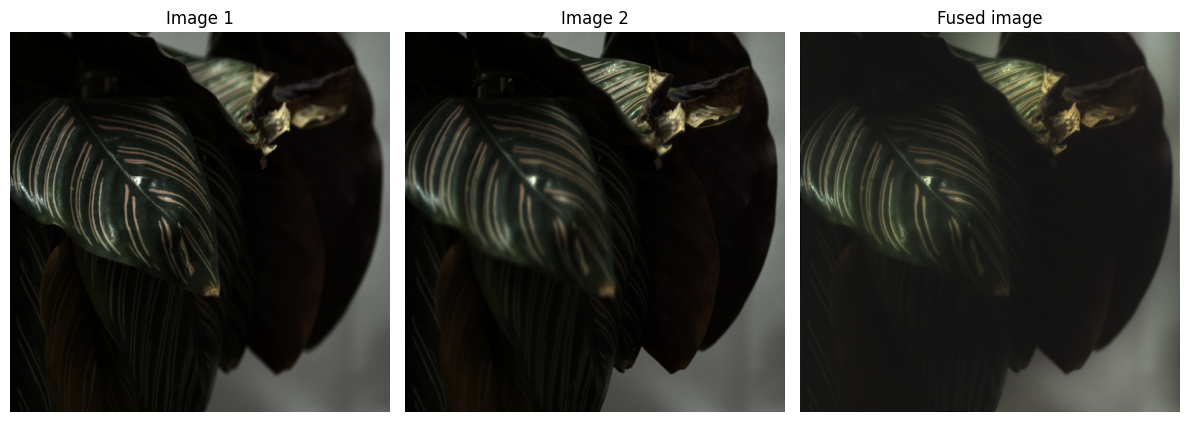

In [46]:
im1 = io.imread('dataset/multi-focus_raw_images/633/633_0.png')
im2 = io.imread('dataset/multi-focus_raw_images/633/633_1.png')

fused_image = guided_filter_fusion(im1, im2)
plt.figure(figsize=(12,5))


plt.subplot(131)
plt.title('Image 1')
plt.imshow(im1,cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Image 2')
plt.imshow(im2,cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Fused image')
plt.imshow(fused_image,cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

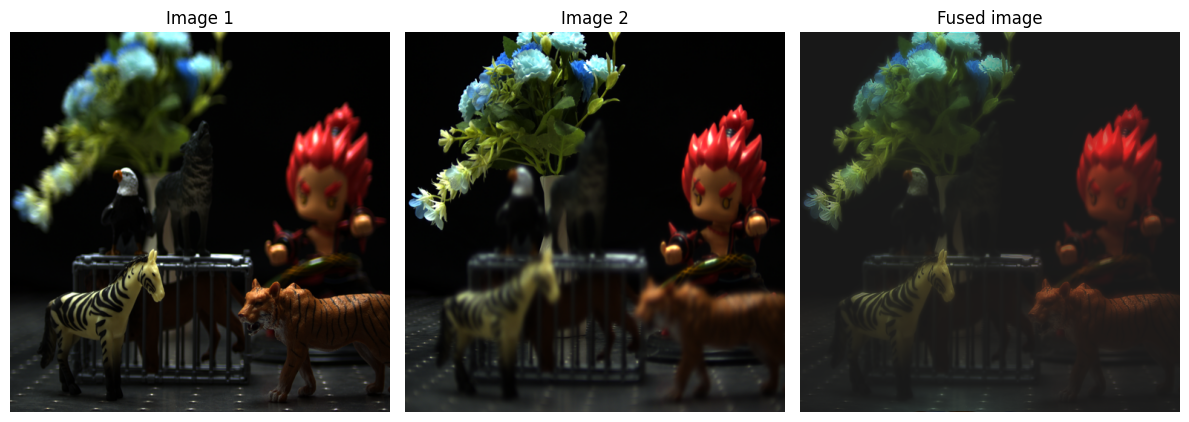

In [43]:
im1 = io.imread('dataset/multi-focus_raw_images/988/988_0.png')
im2 = io.imread('dataset/multi-focus_raw_images/988/988_3.png')

fused_image = guided_filter_fusion(im1, im2)
plt.figure(figsize=(12,5))


plt.subplot(131)
plt.title('Image 1')
plt.imshow(im1)
plt.axis('off')

plt.subplot(132)
plt.title('Image 2')
plt.imshow(im2)
plt.axis('off')

plt.subplot(133)
plt.title('Fused image')
plt.imshow(fused_image)
plt.axis('off')

plt.tight_layout()
plt.show()